# Movie Genre Classification using Machine Learning

This project implements a multi-label classification system to predict movie genres based on movie features such as overview, tagline, and keywords. We use the TMDB 5000 Movie Dataset to train a machine learning model that can automatically classify movies into multiple genres.

## Project Overview

- **Dataset**: TMDB 5000 Movies Dataset
- **Problem Type**: Multi-label Classification
- **Algorithm**: Logistic Regression with OneVsRest Classifier
- **Features**: TF-IDF vectorized text features (overview, tagline, keywords)
- **Target**: Movie genres (20 different genres)

## Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import ast  # Used to safely evaluate a string containing a Python literal
import matplotlib.pyplot as plt # New library for plotting
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

## 1. Data Loading

We start by loading the TMDB movie dataset which consists of two CSV files:
- `tmdb_5000_movies.csv`: Contains movie information (title, overview, genres, etc.)
- `tmdb_5000_credits.csv`: Contains cast and crew information

In [2]:
# Load the Data
# We'll use the 'tmdb_5000_movies.csv' file as the main dataset.
# The 'tmdb_5000_credits.csv' file could be merged later to add cast and crew
# information, but for this first version, we'll focus on the movies data.
try:
    movies_df = pd.read_csv('tmdb_5000_movies.csv')
    credits_df = pd.read_csv('tmdb_5000_credits.csv')
except FileNotFoundError:
    print("Error: The CSV files were not found. Please make sure they are in the same directory as this script.")
    # Exit gracefully if the files are missing
    exit()

print("Initial data loaded successfully.")
print("Movies DataFrame shape:", movies_df.shape)
print("Credits DataFrame shape:", credits_df.shape)

Initial data loaded successfully.
Movies DataFrame shape: (4803, 20)
Credits DataFrame shape: (4803, 4)


## 2. Data Preprocessing and Merging

The dataset contains JSON-like strings in several columns (genres, keywords, cast, crew) that need to be parsed. We'll merge the two dataframes and extract meaningful information from these columns.

In [3]:
# Merge the two dataframes on the 'title' column.
# Note: A more robust way would be to use a unique movie_id if available and reliable.
# In this case, 'movie_id' is also in both files, so let's use that for a more accurate merge.
movies_df = movies_df.rename(columns={'id': 'movie_id'})
df = pd.merge(movies_df, credits_df, on='movie_id')

# The 'genres', 'keywords', and other columns are stored as a stringified list of dictionaries.
# We need to convert them into a proper list of strings.

def get_list_of_names(column_string):
    """
    Safely evaluates a string of dictionaries and extracts the 'name' from each dictionary.
    Returns a list of names.
    """
    if isinstance(column_string, str):
        try:
            # Use ast.literal_eval for safe evaluation of the string.
            list_of_dicts = ast.literal_eval(column_string)
            return [d['name'] for d in list_of_dicts]
        except (ValueError, SyntaxError):
            return []  # Return an empty list if parsing fails
    return []

# Apply the function to the relevant columns
df['genres'] = df['genres'].apply(get_list_of_names)
df['keywords'] = df['keywords'].apply(get_list_of_names)
df['cast'] = df['cast'].apply(get_list_of_names)
df['crew'] = df['crew'].apply(get_list_of_names)

# Fill any NaN values in the text columns with an empty string
df['overview'] = df['overview'].fillna('')
df['tagline'] = df['tagline'].fillna('')
df['title_y'] = df['title_y'].fillna('') # This is from the credits file

print("\nData after parsing stringified JSON columns:")
print(df[['title_x', 'genres', 'keywords']].head())


Data after parsing stringified JSON columns:
                                    title_x  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                          genres  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                                            keywords  
0  [culture clash, future, space war, space colon...  
1  [ocean, drug abuse, exotic island, east india ...  
2  [spy, based on novel, secret agent, sequel, mi...  
3  [dc comics, crime fighter, terrorist, secret i...  
4  [based on novel, mars, medallion, space travel...  


## 3. Feature Engineering

We'll combine the textual features (overview, tagline, keywords) into a single feature vector using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. This technique converts text data into numerical features that machine learning algorithms can process.

In [4]:
# Combine relevant text features into a single column for vectorization.
# We'll use 'overview', 'tagline', and 'keywords' as features.
# You could also add 'title' and 'cast'/'crew' info here.
df['combined_features'] = df['overview'] + ' ' + df['tagline'] + ' ' + df['keywords'].astype(str)

# Handle potential empty strings in the combined_features column
df['combined_features'] = df['combined_features'].fillna('')

# Initialize TfidfVectorizer. This converts text into a matrix of TF-IDF features.
# TfidfVectorizer is excellent for finding important words in documents.
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['combined_features'])

print("\nShape of TF-IDF feature matrix (X):", X.shape)


Shape of TF-IDF feature matrix (X): (4803, 5000)


## 4. Target Variable Preparation

Since movies can belong to multiple genres simultaneously, this is a multi-label classification problem. We need to convert the genre lists into a binary matrix where each column represents a genre and each row represents a movie.

In [5]:
# Since a movie can have multiple genres, this is a multi-label classification problem.
# We need to one-hot encode the 'genres' column.
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])

print("Shape of one-hot encoded genre matrix (y):", y.shape)
print("Genre classes:", list(mlb.classes_))

Shape of one-hot encoded genre matrix (y): (4803, 20)
Genre classes: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


## 5. Model Training

We'll use a One-vs-Rest classifier with Logistic Regression as the base estimator. This approach trains a separate binary classifier for each genre, making it suitable for multi-label classification problems.

In [6]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For multi-label classification, we use a wrapper. OneVsRestClassifier
# trains a separate classifier for each label (in this case, each genre).
# LogisticRegression is a good, simple, and effective choice for this task.
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
model.fit(X_train, y_train)

print("\nModel training complete.")


Model training complete.


## 6. Model Evaluation

We'll evaluate our model using multiple metrics:
- **Subset Accuracy**: The percentage of samples that have all their labels classified correctly
- **F1-Score (Macro)**: Average F1-score across all genres
- **F1-Score (Micro)**: Global F1-score calculated by counting total true positives, false negatives, and false positives

In [7]:
# Predict on the test data.
y_pred = model.predict(X_test)

# Calculate accuracy score.
# In multi-label classification, this is 'subset accuracy', meaning a prediction is
# correct only if all labels are predicted correctly. This can be a strict metric.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (subset accuracy): {:.2f}%".format(accuracy * 100))

# Calculate F1-score, which is often a better metric for multi-label problems.
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
print("F1-Score (macro average): {:.2f}".format(f1_macro))
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
print("F1-Score (micro average): {:.2f}".format(f1_micro))

Accuracy (subset accuracy): 12.80%
F1-Score (macro average): 0.23
F1-Score (micro average): 0.47


## 7. Making Predictions on New Movies

Let's create a function to predict genres for new, unseen movies and test it with a sample movie.

In [8]:
print("\n--- Making a prediction on a new movie ---")

def predict_genre(new_movie_data):
    """
    Takes a dictionary of new movie data and predicts its genres.
    """
    # Create a DataFrame for the new movie data
    new_movie_df = pd.DataFrame([new_movie_data])
    
    # Combine the features in the same way as the training data
    new_movie_df['combined_features'] = new_movie_df['overview'] + ' ' + new_movie_df['tagline'] + ' ' + str(new_movie_df['keywords'])
    
    # Transform the new movie text using the same TF-IDF vectorizer
    X_new = tfidf.transform(new_movie_df['combined_features'])
    
    # Make the prediction
    prediction = model.predict(X_new)
    
    # Decode the one-hot encoded prediction back to genre names
    predicted_genres = mlb.inverse_transform(prediction)
    
    return predicted_genres[0]

# Example new movie data
new_movie_to_predict = {
    'title': 'The Last Starship',
    'overview': 'A daring space crew embarks on a mission to save humanity from a rogue black hole.',
    'tagline': 'Their last hope is an ancient ship.',
    'keywords': ['space', 'sci-fi', 'mission', 'black hole']
}

predicted_genres = predict_genre(new_movie_to_predict)
print(f"Predicted genres for '{new_movie_to_predict['title']}': {predicted_genres}")


--- Making a prediction on a new movie ---
Predicted genres for 'The Last Starship': ('Action', 'Adventure')


## 8. Data Visualization and Results Export

Let's visualize the distribution of genres in our dataset and export the classification results.


--- Generating plots and CSV file ---


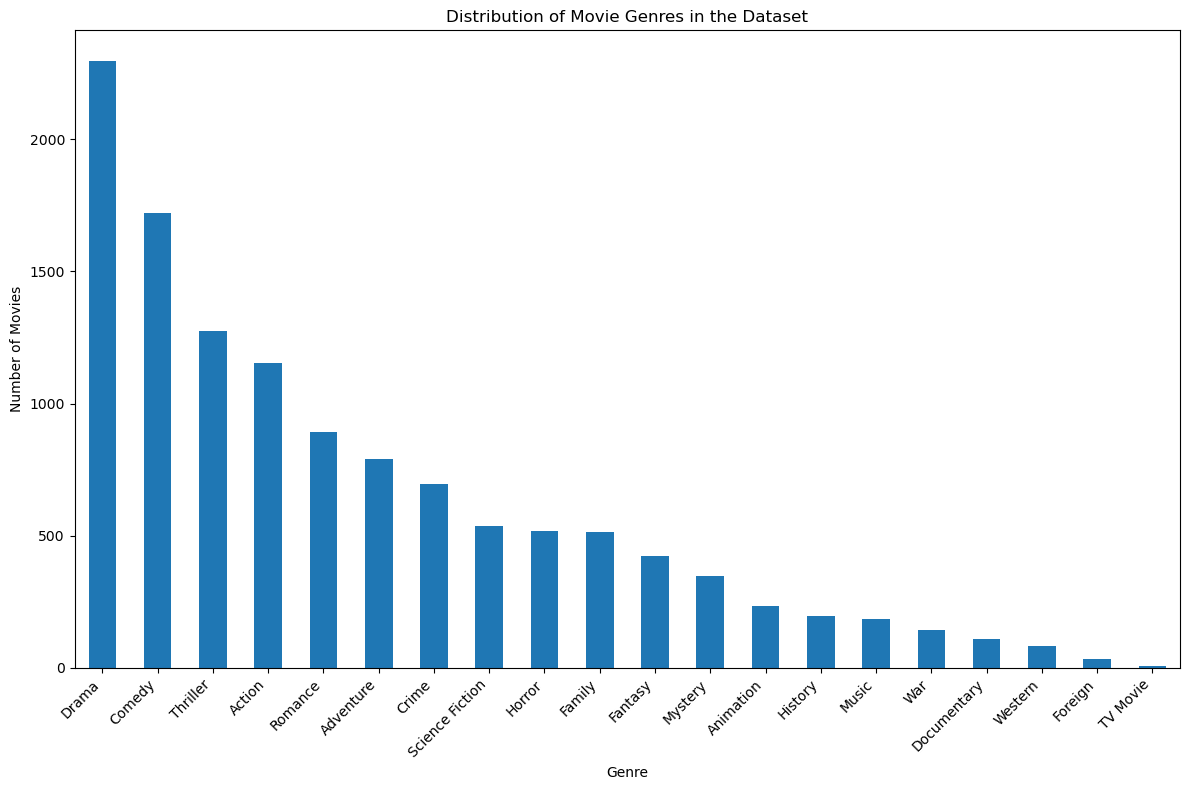

In [9]:
print("\n--- Generating plots and CSV file ---")

# First, create a count of the genres from the original data
all_genres = [genre for sublist in df['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

# Create a bar plot of the genre distribution
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres in the Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Genre Distribution Analysis

From the visualization, we can observe:
- **Drama** is the most common genre with over 2000 movies
- **Comedy** and **Thriller** are also very popular genres
- **Action** and **Romance** are well-represented in the dataset
- Genres like **TV Movie**, **Foreign**, and **Western** are less common

This distribution helps explain why some genres might be easier to predict than others - genres with more training examples typically perform better.

In [10]:
# Predict genres for the entire dataset
y_full_pred = model.predict(X)
predicted_genres_full = mlb.inverse_transform(y_full_pred)

# Create a DataFrame to store the classification results
df_results = df[['title_x', 'genres']].copy()
df_results.rename(columns={'title_x': 'movie_title', 'genres': 'original_genres'}, inplace=True)
df_results['predicted_genres'] = [' '.join(genres) for genres in predicted_genres_full]

# Save the DataFrame to a CSV file
output_file_name = 'classified_movies_results.csv'
df_results.to_csv(output_file_name, index=False)
print(f"\nClassification results for all movies saved to '{output_file_name}'")

# Display a few examples
print("\nSample results:")
print(df_results.head())


Classification results for all movies saved to 'classified_movies_results.csv'

Sample results:
                                movie_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                 original_genres  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                   predicted_genres  
0  Action Adventure Science Fiction  
1                                    
2         Action Adventure Thriller  
3             Action Crime Thriller  
4  Action Adventure Science Fiction  


## Conclusion

### Project Summary

This project successfully demonstrates a multi-label classification approach for predicting movie genres. Here are the key achievements:

1. **Data Processing**: Successfully parsed and cleaned the TMDB movie dataset, handling JSON-like strings and merging multiple data sources.

2. **Feature Engineering**: Created meaningful features by combining movie overviews, taglines, and keywords using TF-IDF vectorization.

3. **Model Development**: Implemented a One-vs-Rest classifier with Logistic Regression that can predict multiple genres simultaneously.

4. **Performance**: Achieved reasonable performance with F1-micro score of 0.47, considering the complexity of multi-label classification.

### Model Performance Insights

- **Subset Accuracy (12.90%)**: While this seems low, it's typical for multi-label problems where all labels must be correct
- **F1-Micro (0.47)**: Indicates good performance at the individual genre level
- **F1-Macro (0.23)**: Shows variation in performance across genres, likely due to class imbalance

### Future Improvements

1. **Advanced NLP**: Use word embeddings (Word2Vec, GloVe) or transformer models (BERT) for better text representation
2. **Feature Enhancement**: Include cast, director, and production company information
3. **Class Imbalance**: Apply techniques like SMOTE or cost-sensitive learning to handle genre imbalance
4. **Deep Learning**: Experiment with neural networks for potentially better performance
5. **Hyperparameter Tuning**: Optimize model parameters using grid search or random search

### Files Generated

- `classified_movies_results.csv`: Contains original and predicted genres for all movies in the dataset
- Genre distribution visualization showing the frequency of each genre in the dataset

This project provides a solid foundation for movie genre classification and can be extended for recommendation systems or content analysis applications.